In [1]:
from owslib.wmts import WebMapTileService
from IPython.display import Image, display
import time
import math
import WMTS_General_Map as general
config = general.get_config_from_json()

## Experimental Testing for getting photo's out of multiple WMTS servers.
This Notebook experiments with a way  to get photo's as a datasource to later integrate it into the SailingRobots Website. 

The static variables like the website and the normal map layer.

In [2]:
try:
    wmts_avoin = WebMapTileService(config["wmts"]["avoin"])
    time.sleep(0.01)
    wmts_maasto = WebMapTileService(config["wmts"]["maasto"])
except Exception as e:
    print(e)
    exit();
tile_matrix_set_name = config["matrix"]["set_name"]
map_layer = config["matrix"]["map_layer"]["orto"]
standardized_rendering_pixel_size = config["standardized_rendering_pixel_size"]

Get a single image information calculated by the coordinates given. This is so that we can later get images for multiple points and see which of these is at a certain water depth.

In [3]:
def get_single_height_width(matrix, lat, lon):
    delta_width = matrix.tilewidth * standardized_rendering_pixel_size * matrix.scaledenominator
    delta_height = matrix.tileheight * standardized_rendering_pixel_size * matrix.scaledenominator
    finn_coordinates = general.convert_coordinate_systems(lat=lat, lon=lon, inverse=True)

    width = math.trunc((finn_coordinates[0] - matrix.topleftcorner[0]) / delta_width)
    height = math.trunc((matrix.topleftcorner[1] - finn_coordinates[1]) / delta_height)
    return height, width

If the tileset is not given it calculates the matrix and and set's the default level.

In [4]:
def get_column_row_for_coordinate_at_level_single(latitude, longitude, wmts, tileset=None, level=2):
    if tileset == None:
        tileset = wmts.tilematrixsets[tile_matrix_set_name]
        list_of_tilematrixes = list(tileset.tilematrix.keys())
    return get_single_height_width(
        tileset.tilematrix[list_of_tilematrixes[level]], 
        lat=latitude, 
        lon=longitude)

This method executes the other methods and displays the image. 

In [5]:
def get_image_for_coordinate(latitude, longitude, level, wmts_, specified_map_layer=map_layer):
    codes = get_column_row_for_coordinate_at_level_single(latitude=latitude,
                                                          longitude=longitude,
                                                          wmts=wmts_,
                                                          level=level)
    tile = wmts_.gettile(layer=specified_map_layer,
                         tilematrixset=tile_matrix_set_name,
                         tilematrix='{0}'.format(level),
                         row=codes[0],
                         column=codes[1],
                         format= wmts_.contents[specified_map_layer].formats[0])
    return Image(tile.read())

The execution of getting a certain images from the coordinates file. it also has an infrared option at maasto

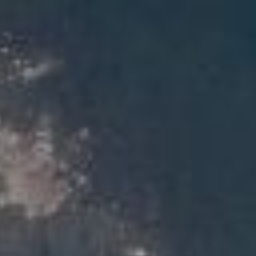

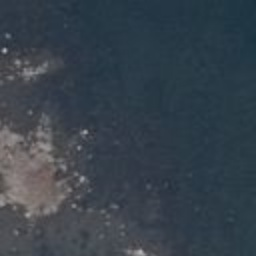

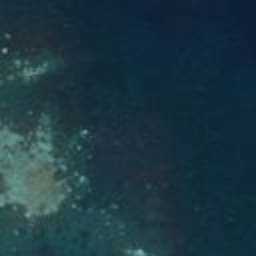

In [6]:
info_dict = general.get_coordinates_from_file()[0]

img = get_image_for_coordinate(info_dict['latitude'], 
                         info_dict['longitude'], 
                         info_dict['level'], 
                         wmts_=wmts_avoin)
img_2 = get_image_for_coordinate(info_dict['latitude'], 
                         info_dict['longitude'], 
                         info_dict['level'], 
                         wmts_=wmts_maasto)
img_3 = get_image_for_coordinate(info_dict['latitude'], 
                         info_dict['longitude'], 
                         info_dict['level'], 
                         wmts_=wmts_maasto, 
                         specified_map_layer=config["matrix"]["map_layer"]["infrared"])
display(img,img_2,img_3)